In [93]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from matplotlib.patches import Circle
import os
import pickle
from scipy.stats import mannwhitneyu, ttest_ind, kruskal, f_oneway
from statannotations.Annotator import Annotator
from itertools import combinations
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import clear_output, display
import sys
from matplotlib.lines import Line2D
sys.path.append('../scripts') 
from functions import *
from config import nutrient_info, conversion_factors

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
df_food_scaled = pd.read_csv('../data/df_food_scaled.csv')
df_food_clean_outliers = pd.read_csv('../data/df_food_clean_outliers.csv')

C:\Users\Sophie\AppData\Local\Temp\ipykernel_18772\1779815426.py:1: DtypeWarning: Columns (1,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food_scaled = pd.read_csv('../data/df_food_scaled.csv')
C:\Users\Sophie\AppData\Local\Temp\ipykernel_18772\1779815426.py:2: DtypeWarning: Columns (1,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food_clean_outliers = pd.read_csv('../data/df_food_clean_outliers.csv')


In [4]:
df_food_clean_outliers

,food_id,barcode,dish_id,eaten_quantity,eaten_unit,subject_key,eaten_at,eaten_at_utc_offset,media_count,food_group_cname,...,protein_eaten_ratio_scaled,fat_eaten_ratio_scaled,fatty_acids_saturated_eaten_ratio_scaled,cholesterol_eaten_ratio_scaled,sugar_eaten_ratio_scaled,sodium_eaten_ratio_scaled,salt_eaten_ratio_scaled,QI,DI,NB
0,13,0,335994,110.00,g,bjsqab,2022-02-15 18:06:27,60,1,dairy_products_meat_fish_eggs_tofu,...,7.936971,0.774393,1.037218,3.93736,0.000000,0.430649,0.000000,2.498497,1.029937,67.110660
1,13,0,411384,100.00,g,erv9jd,2023-01-18 13:08:53,60,1,dairy_products_meat_fish_eggs_tofu,...,7.936971,0.774393,1.037218,3.93736,0.000000,0.430649,0.000000,2.498497,1.029937,67.110660
2,25,0,202497,35.00,g,6ata8r,2021-03-30 13:52:23,120,1,vegetables_fruits,...,0.341006,0.100553,0.000000,0.00000,3.545098,0.032680,0.000000,1.047794,0.613055,61.770389
3,25,0,283397,35.00,g,uzbc9s,2021-10-21 10:09:09,120,1,vegetables_fruits,...,0.341006,0.100553,0.000000,0.00000,3.545098,0.032680,0.000000,1.047794,0.613055,61.770389
4,25,0,266679,40.00,g,fvh6kf,2021-09-19 10:14:35,120,1,vegetables_fruits,...,0.341006,0.100553,0.000000,0.00000,3.545098,0.032680,0.000000,1.047794,0.613055,61.770389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284984,46573,4104420237155,426463,16.00,g,pgeyqb,2023-03-13 15:16:39,60,0,unclassified,...,0.917747,0.202963,0.263852,0.00000,0.633245,0.000000,0.026385,0.090215,0.187741,9.021452
284985,46573,4104420237155,426838,16.00,g,pgeyqb,2023-03-13 15:30:54,60,0,unclassified,...,0.917747,0.202963,0.263852,0.00000,0.633245,0.000000,0.026385,0.090215,0.187741,9.021452
284986,46575,5411188102809,423445,100.00,g,kmxhmz,2023-02-25 08:18:11,60,1,unclassified,...,2.144133,0.702494,0.373599,0.00000,2.060274,0.000000,0.958904,0.952744,0.682545,30.000000
284987,46588,7618500940806,425332,100.00,ml,pgeyqb,2023-03-06 18:31:08,60,1,unclassified,...,1.185771,0.000000,0.000000,0.00000,2.909091,0.000000,15.151515,0.786561,3.010101,10.000000


In [5]:
df_food_clean_outliers['eaten_at'] = pd.to_datetime(df_food_clean_outliers['eaten_at'])
df_food_clean_outliers['date'] = df_food_clean_outliers['eaten_at'].dt.date

In [6]:
df_food_clean_outliers['meal'] = df_food_clean_outliers['eaten_at'].apply(classify_meal_time)

In [7]:
df_food_clean_outliers

,food_id,barcode,dish_id,eaten_quantity,eaten_unit,subject_key,eaten_at,eaten_at_utc_offset,media_count,food_group_cname,...,fatty_acids_saturated_eaten_ratio_scaled,cholesterol_eaten_ratio_scaled,sugar_eaten_ratio_scaled,sodium_eaten_ratio_scaled,salt_eaten_ratio_scaled,QI,DI,NB,date,meal
0,13,0,335994,110.00,g,bjsqab,2022-02-15 18:06:27,60,1,dairy_products_meat_fish_eggs_tofu,...,1.037218,3.93736,0.000000,0.430649,0.000000,2.498497,1.029937,67.110660,2022-02-15,dinner
1,13,0,411384,100.00,g,erv9jd,2023-01-18 13:08:53,60,1,dairy_products_meat_fish_eggs_tofu,...,1.037218,3.93736,0.000000,0.430649,0.000000,2.498497,1.029937,67.110660,2023-01-18,lunch
2,25,0,202497,35.00,g,6ata8r,2021-03-30 13:52:23,120,1,vegetables_fruits,...,0.000000,0.00000,3.545098,0.032680,0.000000,1.047794,0.613055,61.770389,2021-03-30,lunch
3,25,0,283397,35.00,g,uzbc9s,2021-10-21 10:09:09,120,1,vegetables_fruits,...,0.000000,0.00000,3.545098,0.032680,0.000000,1.047794,0.613055,61.770389,2021-10-21,None
4,25,0,266679,40.00,g,fvh6kf,2021-09-19 10:14:35,120,1,vegetables_fruits,...,0.000000,0.00000,3.545098,0.032680,0.000000,1.047794,0.613055,61.770389,2021-09-19,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284984,46573,4104420237155,426463,16.00,g,pgeyqb,2023-03-13 15:16:39,60,0,unclassified,...,0.263852,0.00000,0.633245,0.000000,0.026385,0.090215,0.187741,9.021452,2023-03-13,snack
284985,46573,4104420237155,426838,16.00,g,pgeyqb,2023-03-13 15:30:54,60,0,unclassified,...,0.263852,0.00000,0.633245,0.000000,0.026385,0.090215,0.187741,9.021452,2023-03-13,snack
284986,46575,5411188102809,423445,100.00,g,kmxhmz,2023-02-25 08:18:11,60,1,unclassified,...,0.373599,0.00000,2.060274,0.000000,0.958904,0.952744,0.682545,30.000000,2023-02-25,breakfast
284987,46588,7618500940806,425332,100.00,ml,pgeyqb,2023-03-06 18:31:08,60,1,unclassified,...,0.000000,0.00000,2.909091,0.000000,15.151515,0.786561,3.010101,10.000000,2023-03-06,dinner


In [8]:
composite_meals = df_food_clean_outliers.groupby(['subject_key', 'date', 'meal']).apply(
    lambda g: pd.Series({
        'total_energy': g['energy_kcal_eaten'].sum(),
        'QI': weighted_mean(g['QI'], g['energy_kcal_eaten']),
        'DI': weighted_mean(g['DI'], g['energy_kcal_eaten']),
        'NB': weighted_mean(g['NB'], g['energy_kcal_eaten'])
    })
).reset_index()

C:\Users\Sophie\AppData\Local\Temp\ipykernel_18772\3910164952.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  composite_meals = df_food_clean_outliers.groupby(['subject_key', 'date', 'meal']).apply(


In [9]:
composite_meals

,subject_key,date,meal,total_energy,QI,DI,NB
0,02ae3856ca04,2018-11-26,breakfast,575.00,0.713199,0.798634,41.205509
1,02ae3856ca04,2018-11-26,dinner,1287.00,0.598050,0.729423,25.860366
2,02ae3856ca04,2018-11-26,lunch,2.00,2.115202,0.090278,35.000000
3,02ae3856ca04,2018-11-26,snack,712.40,1.135763,1.184370,48.454579
4,02ae3856ca04,2018-11-27,breakfast,306.20,0.523551,0.863543,41.538789
...,...,...,...,...,...,...,...
44325,zznk4w,2022-09-24,breakfast,955.85,0.597726,1.036774,24.040702
44326,zznk4w,2022-09-24,dinner,720.05,0.256130,0.985080,20.958660
44327,zznk4w,2022-09-24,lunch,795.25,0.212611,0.752383,17.993521
44328,zznk4w,2022-09-24,snack,132.70,0.778478,0.852516,28.638771


In [10]:
composite_meals.to_csv('../data/composite_meals.csv', index=False)

## Breakfast analysis

In [11]:
df_breakfast = df_food_clean_outliers[df_food_clean_outliers['meal'] == 'breakfast']
df_breakfast

,food_id,barcode,dish_id,eaten_quantity,eaten_unit,subject_key,eaten_at,eaten_at_utc_offset,media_count,food_group_cname,...,fatty_acids_saturated_eaten_ratio_scaled,cholesterol_eaten_ratio_scaled,sugar_eaten_ratio_scaled,sodium_eaten_ratio_scaled,salt_eaten_ratio_scaled,QI,DI,NB,date,meal
18,26,0,126878,40.0,g,uwbvad,2020-06-05 09:53:29,120,1,vegetables_fruits,...,0.000000,0.0,3.714943,0.017241,0.000000,0.557710,0.631855,45.415146,2020-06-05,breakfast
50,26,0,216356,20.0,g,q2zqrx,2021-04-29 09:57:49,120,1,vegetables_fruits,...,0.000000,0.0,3.714943,0.017241,0.000000,0.557710,0.631855,45.415146,2021-04-29,breakfast
109,50,0,71809,20.0,g,ujjybm,2019-10-18 09:43:41,120,1,vegetables_fruits,...,0.000000,0.0,2.947368,0.847953,0.000000,1.679289,0.640051,69.928989,2019-10-18,breakfast
175,50,0,128131,45.0,g,ax9a5v,2020-06-10 07:06:42,120,1,vegetables_fruits,...,0.000000,0.0,2.947368,0.847953,0.000000,1.679289,0.640051,69.928989,2020-06-10,breakfast
211,50,0,150506,140.0,g,kgznn6,2020-10-05 09:59:13,120,1,vegetables_fruits,...,0.000000,0.0,2.947368,0.847953,0.000000,1.679289,0.640051,69.928989,2020-10-05,breakfast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284910,46330,7627534848682,413781,150.0,g,2xpx82,2023-01-26 09:51:24,60,0,unclassified,...,0.000000,0.0,0.918519,0.000000,0.246914,0.402576,0.194239,5.000000,2023-01-26,breakfast
284927,46360,4260289447057,416722,55.0,g,zgnzkr,2023-02-03 07:02:13,60,0,unclassified,...,0.437530,0.0,0.701604,0.000000,1.960784,2.626423,0.609208,77.994652,2023-02-03,breakfast
284956,46431,7613404449271,419746,180.0,g,xek94s,2023-02-11 09:50:14,60,0,unclassified,...,1.722488,0.0,2.021053,0.000000,0.350877,0.105721,0.821854,7.105263,2023-02-11,breakfast
284966,46444,7613404894750,422336,150.0,g,xek94s,2023-02-19 07:47:27,60,0,unclassified,...,3.230654,0.0,1.295868,0.000000,0.220386,0.080920,1.048974,6.983471,2023-02-19,breakfast


In [12]:
composite_breakfast = df_breakfast.groupby(['subject_key', 'date']).apply(
    lambda g: pd.Series({
        'total_energy': g['energy_kcal_eaten'].sum(),
        'QI': weighted_mean(g['QI'], g['energy_kcal_eaten']),
        'DI': weighted_mean(g['DI'], g['energy_kcal_eaten']),
        'NB': weighted_mean(g['NB'], g['energy_kcal_eaten'])
    })
).reset_index()

C:\Users\Sophie\AppData\Local\Temp\ipykernel_18772\3829256653.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  composite_breakfast = df_breakfast.groupby(['subject_key', 'date']).apply(


In [13]:
composite_breakfast['breakfast_time'] = pd.to_datetime(composite_breakfast['date'].astype(str)) + pd.Timedelta(hours=8)

In [14]:
composite_breakfast = composite_breakfast[composite_breakfast['total_energy'] > 100]

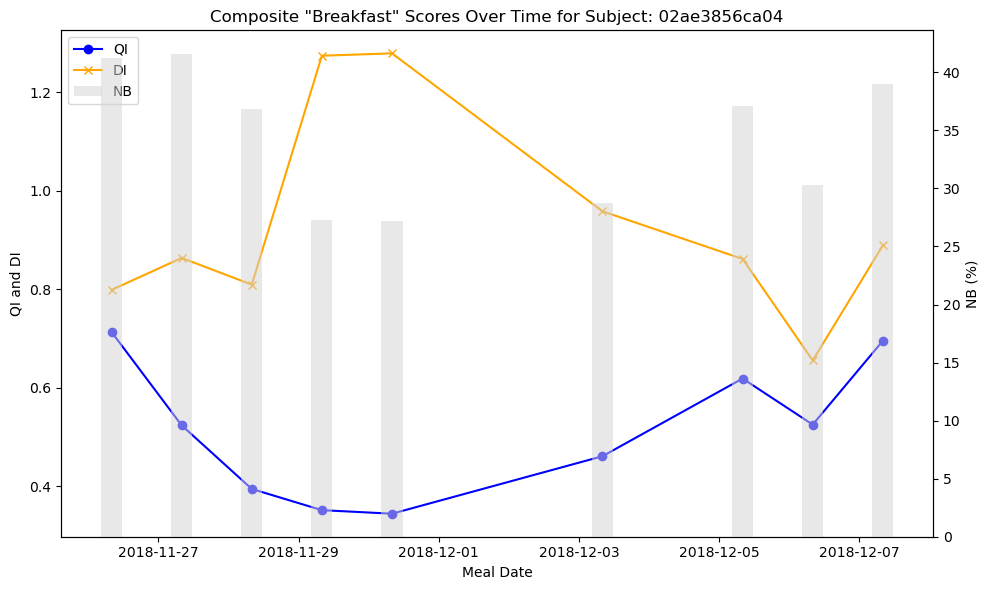

,subject_key,date,total_energy,QI,DI,NB,breakfast_time
0,02ae3856ca04,2018-11-26,575.00,0.713199,0.798634,41.205509,2018-11-26 08:00:00
1,02ae3856ca04,2018-11-27,306.20,0.523551,0.863543,41.538789,2018-11-27 08:00:00
2,02ae3856ca04,2018-11-28,266.20,0.394379,0.809386,36.802253,2018-11-28 08:00:00
3,02ae3856ca04,2018-11-29,492.00,0.351299,1.274242,27.238931,2018-11-29 08:00:00
4,02ae3856ca04,2018-11-30,490.00,0.344100,1.279075,27.207253,2018-11-30 08:00:00
5,02ae3856ca04,2018-12-03,499.80,0.460771,0.958368,28.730609,2018-12-03 08:00:00
6,02ae3856ca04,2018-12-05,537.70,0.618625,0.861459,37.128733,2018-12-05 08:00:00
7,02ae3856ca04,2018-12-06,508.25,0.525091,0.655378,30.335425,2018-12-06 08:00:00
8,02ae3856ca04,2018-12-07,337.05,0.695228,0.888990,38.950670,2018-12-07 08:00:00


In [15]:
subject_id = '02ae3856ca04'
subject_breakfast = composite_breakfast[composite_breakfast['subject_key'] == subject_id]

plot_meal(composite_breakfast[composite_breakfast['subject_key'] == subject_id],
                      subject_id,
                      meal_name='breakfast',
                      time_column='breakfast_time')
subject_breakfast

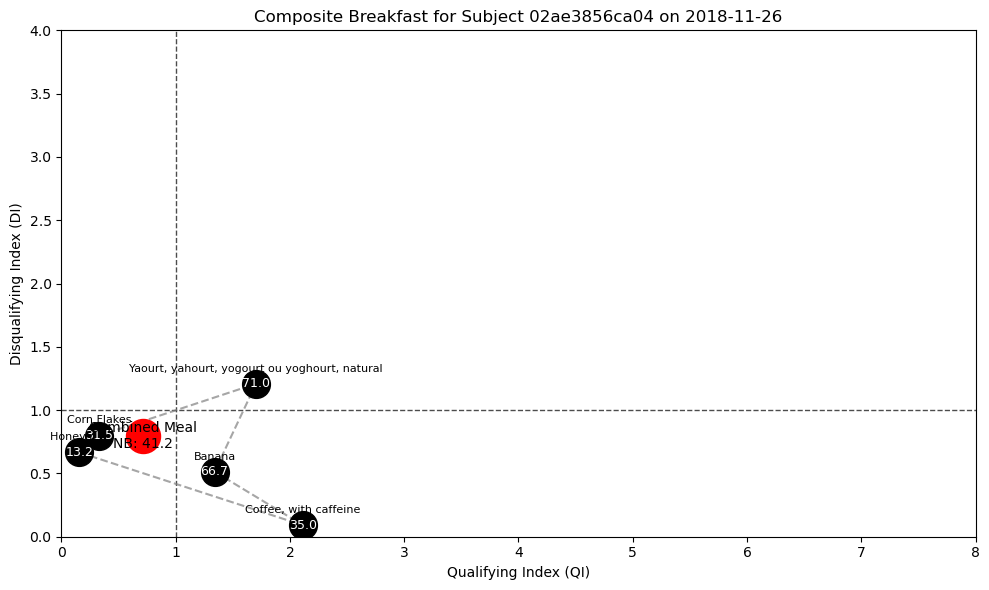

In [16]:
subject_id = '02ae3856ca04'
target_date = pd.to_datetime('2018-11-26').date()
meal_name = 'breakfast'

plot_meal_composite(df_food_clean_outliers, subject_id, target_date, meal_name)

## Lunch analysis

In [17]:
df_lunch = df_food_clean_outliers[df_food_clean_outliers['meal'] == 'lunch']

In [18]:
composite_lunch = df_lunch.groupby(['subject_key', 'date']).apply(
    lambda g: pd.Series({
        'total_energy': g['energy_kcal_eaten'].sum(),
        'QI': weighted_mean(g['QI'], g['energy_kcal_eaten']),
        'DI': weighted_mean(g['DI'], g['energy_kcal_eaten']),
        'NB': weighted_mean(g['NB'], g['energy_kcal_eaten'])
    })
).reset_index()

C:\Users\Sophie\AppData\Local\Temp\ipykernel_18772\2398471281.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  composite_lunch = df_lunch.groupby(['subject_key', 'date']).apply(


In [19]:
composite_lunch['lunch_time'] = pd.to_datetime(composite_lunch['date'].astype(str)) + pd.Timedelta(hours=12)
composite_lunch = composite_lunch[composite_lunch['total_energy'] > 100]


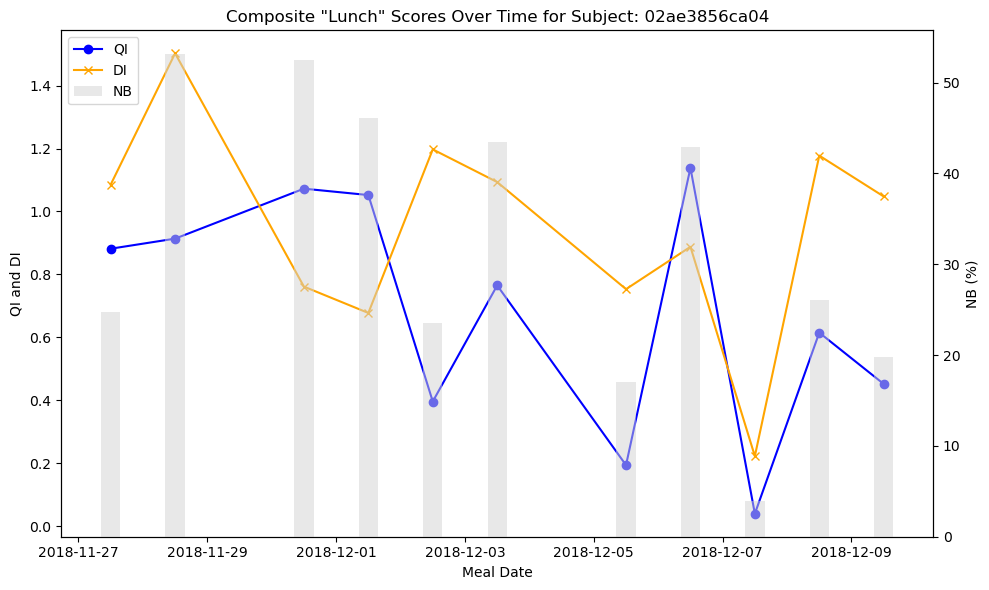

,subject_key,date,total_energy,QI,DI,NB,lunch_time
1,02ae3856ca04,2018-11-27,613.80,0.881612,1.085315,24.778578,2018-11-27 12:00:00
2,02ae3856ca04,2018-11-28,1748.15,0.913648,1.502373,53.090586,2018-11-28 12:00:00
3,02ae3856ca04,2018-11-30,328.70,1.072399,0.761136,52.450506,2018-11-30 12:00:00
4,02ae3856ca04,2018-12-01,588.80,1.052112,0.677477,46.042437,2018-12-01 12:00:00
5,02ae3856ca04,2018-12-02,607.20,0.396113,1.197229,23.507088,2018-12-02 12:00:00
6,02ae3856ca04,2018-12-03,431.60,0.765031,1.093389,43.501775,2018-12-03 12:00:00
7,02ae3856ca04,2018-12-05,534.00,0.193979,0.753110,17.078819,2018-12-05 12:00:00
8,02ae3856ca04,2018-12-06,395.58,1.138349,0.887722,42.913938,2018-12-06 12:00:00
9,02ae3856ca04,2018-12-07,249.60,0.039629,0.222578,3.962862,2018-12-07 12:00:00
10,02ae3856ca04,2018-12-08,711.70,0.614942,1.177451,26.068603,2018-12-08 12:00:00


In [20]:
subject_id = '02ae3856ca04'
subject_lunch = composite_lunch[composite_lunch['subject_key'] == subject_id]

plot_meal(composite_lunch[composite_lunch['subject_key'] == subject_id],
                      subject_id,
                      meal_name='lunch',
                      time_column='lunch_time')
subject_lunch

## Snack analysis

In [21]:
df_snack = df_food_clean_outliers[df_food_clean_outliers['meal'] == 'snack']

In [22]:
composite_snack = df_snack.groupby(['subject_key', 'date']).apply(
    lambda g: pd.Series({
        'total_energy': g['energy_kcal_eaten'].sum(),
        'QI': weighted_mean(g['QI'], g['energy_kcal_eaten']),
        'DI': weighted_mean(g['DI'], g['energy_kcal_eaten']),
        'NB': weighted_mean(g['NB'], g['energy_kcal_eaten'])
    })
).reset_index()

C:\Users\Sophie\AppData\Local\Temp\ipykernel_18772\3219763102.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  composite_snack = df_snack.groupby(['subject_key', 'date']).apply(


In [23]:
composite_snack['snack_time'] = pd.to_datetime(composite_lunch['date'].astype(str)) + pd.Timedelta(hours=16)

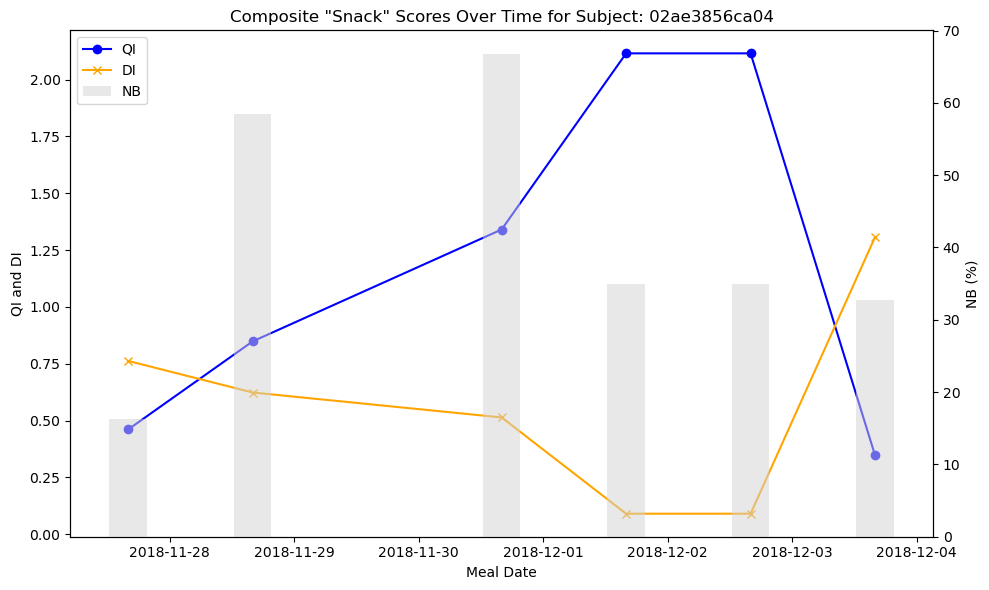

,subject_key,date,total_energy,QI,DI,NB,snack_time
0,02ae3856ca04,2018-11-26,712.40,1.135763,1.184370,48.454579,NaT
1,02ae3856ca04,2018-11-27,462.05,0.460782,0.762320,16.318749,2018-11-27 16:00:00
2,02ae3856ca04,2018-11-29,66.00,0.848266,0.623383,58.426652,2018-11-28 16:00:00
3,02ae3856ca04,2018-11-30,114.00,1.340383,0.513713,66.693436,2018-11-30 16:00:00
4,02ae3856ca04,2018-12-02,2.00,2.115202,0.090278,35.000000,2018-12-01 16:00:00
5,02ae3856ca04,2018-12-05,2.00,2.115202,0.090278,35.000000,2018-12-02 16:00:00
6,02ae3856ca04,2018-12-07,433.65,0.346769,1.307391,32.800593,2018-12-03 16:00:00


In [24]:
subject_id = '02ae3856ca04'
subject_snack = composite_snack[composite_snack['subject_key'] == subject_id]

plot_meal(composite_snack[composite_snack['subject_key'] == subject_id],
                      subject_id,
                      meal_name='snack',
                      time_column='snack_time')
subject_snack

## Dinner analysis

In [25]:
df_dinner = df_food_clean_outliers[df_food_clean_outliers['meal'] == 'dinner']

In [26]:
composite_dinner = df_dinner.groupby(['subject_key', 'date']).apply(
    lambda g: pd.Series({
        'total_energy': g['energy_kcal_eaten'].sum(),
        'QI': weighted_mean(g['QI'], g['energy_kcal_eaten']),
        'DI': weighted_mean(g['DI'], g['energy_kcal_eaten']),
        'NB': weighted_mean(g['NB'], g['energy_kcal_eaten'])
    })
).reset_index()

C:\Users\Sophie\AppData\Local\Temp\ipykernel_18772\25948918.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  composite_dinner = df_dinner.groupby(['subject_key', 'date']).apply(


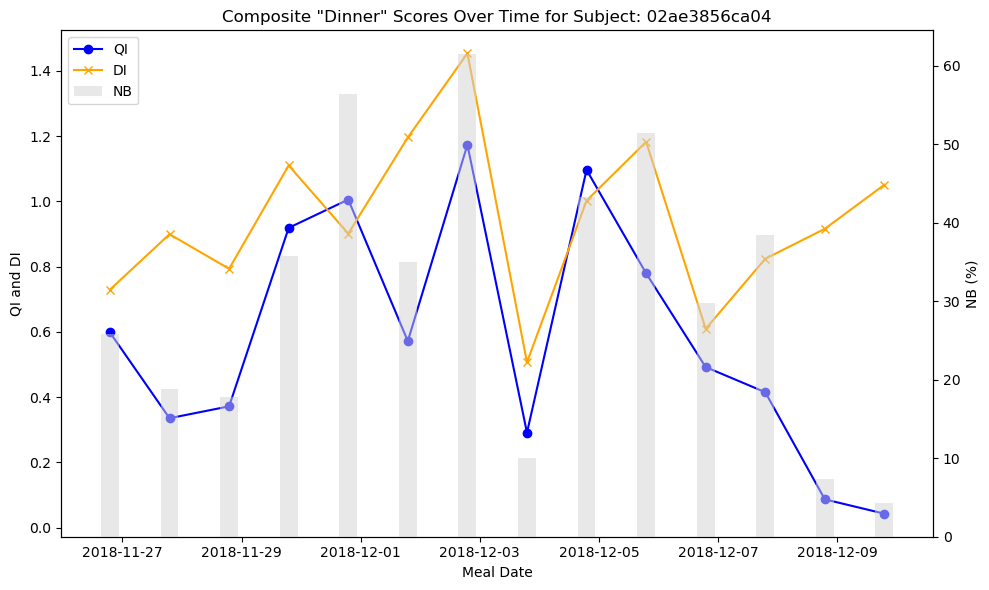

,subject_key,date,total_energy,QI,DI,NB,dinner_time
0,02ae3856ca04,2018-11-26,1287.000,0.598050,0.729423,25.860366,2018-11-26 19:00:00
1,02ae3856ca04,2018-11-27,1772.700,0.335358,0.899210,18.770191,2018-11-27 19:00:00
2,02ae3856ca04,2018-11-28,1720.200,0.371759,0.793216,17.781245,2018-11-28 19:00:00
3,02ae3856ca04,2018-11-29,1284.852,0.918654,1.109955,35.729780,2018-11-29 19:00:00
4,02ae3856ca04,2018-11-30,706.450,1.005433,0.901044,56.380328,2018-11-30 19:00:00
5,02ae3856ca04,2018-12-01,821.850,0.571683,1.195745,35.039438,2018-12-01 19:00:00
6,02ae3856ca04,2018-12-02,779.800,1.173223,1.453405,61.467521,2018-12-02 19:00:00
7,02ae3856ca04,2018-12-03,264.000,0.291087,0.506614,10.000000,2018-12-03 19:00:00
8,02ae3856ca04,2018-12-04,664.060,1.096356,1.002077,43.270368,2018-12-04 19:00:00
9,02ae3856ca04,2018-12-05,828.840,0.779392,1.182379,51.489947,2018-12-05 19:00:00


In [27]:
composite_dinner['dinner_time'] = pd.to_datetime(composite_dinner['date'].astype(str)) + pd.Timedelta(hours=19)
composite_dinner = composite_dinner[composite_dinner['total_energy'] > 100]

subject_id = '02ae3856ca04'
subject_dinner = composite_dinner[composite_dinner['subject_key'] == subject_id]

plot_meal(composite_dinner[composite_dinner['subject_key'] == subject_id],
                      subject_id,
                      meal_name='dinner',
                      time_column='dinner_time')
subject_dinner

# Meals analysis for a whole day

In [28]:

save_directory = "composite_meals_graphs"


Plotting breakfast for subject 02ae3856ca04 and saving to composite_meals_graphs\composite_breakfast_subject_02ae3856ca04.png.


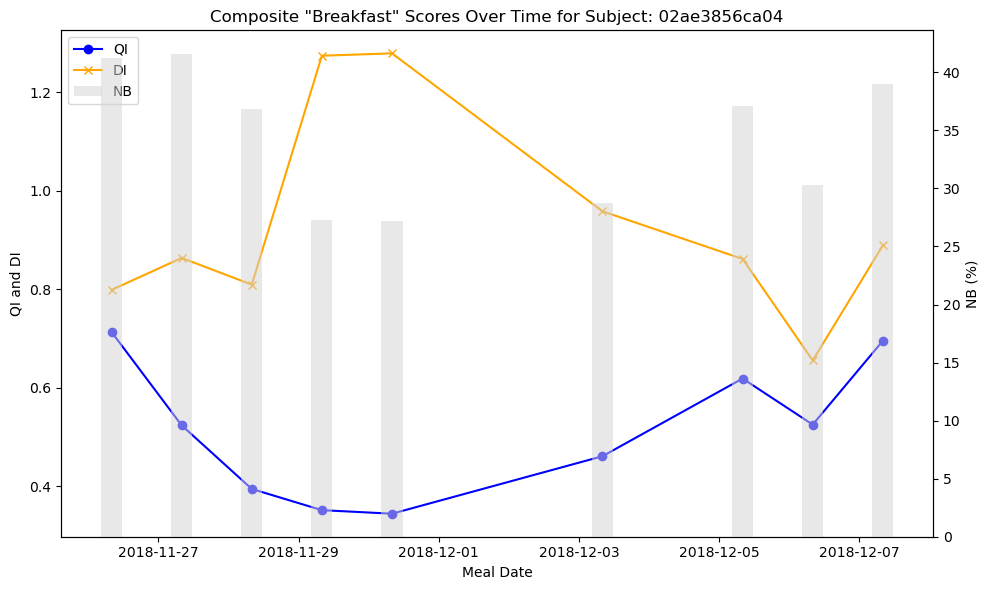

Plotting lunch for subject 02ae3856ca04 and saving to composite_meals_graphs\composite_lunch_subject_02ae3856ca04.png.


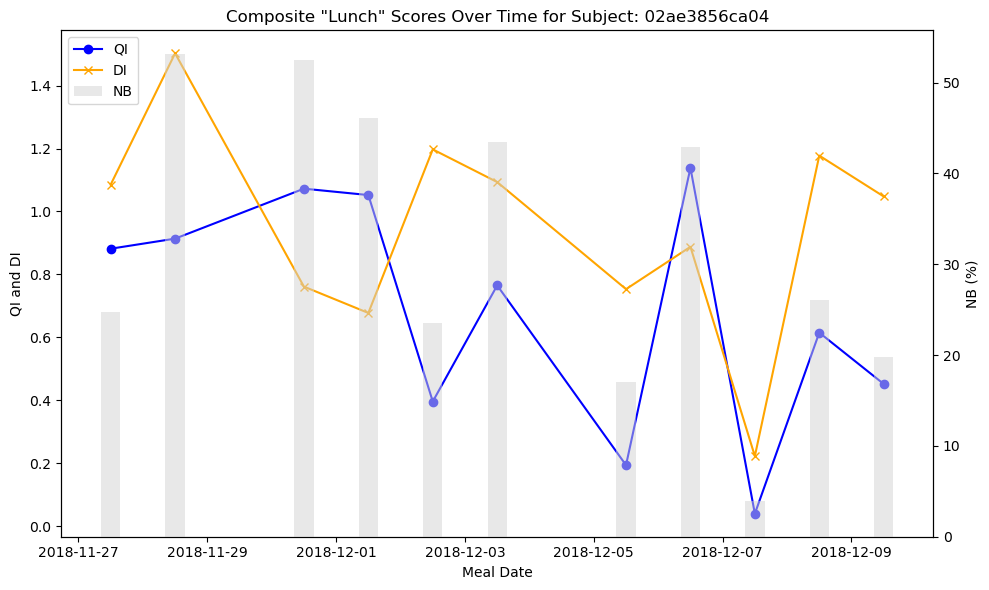

Plotting snack for subject 02ae3856ca04 and saving to composite_meals_graphs\composite_snack_subject_02ae3856ca04.png.


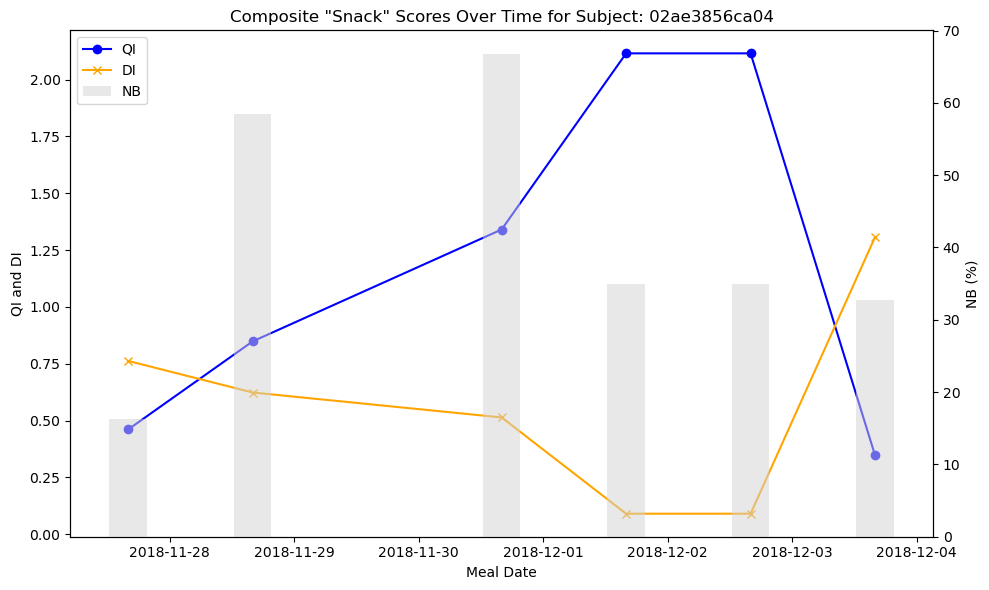

Plotting dinner for subject 02ae3856ca04 and saving to composite_meals_graphs\composite_dinner_subject_02ae3856ca04.png.


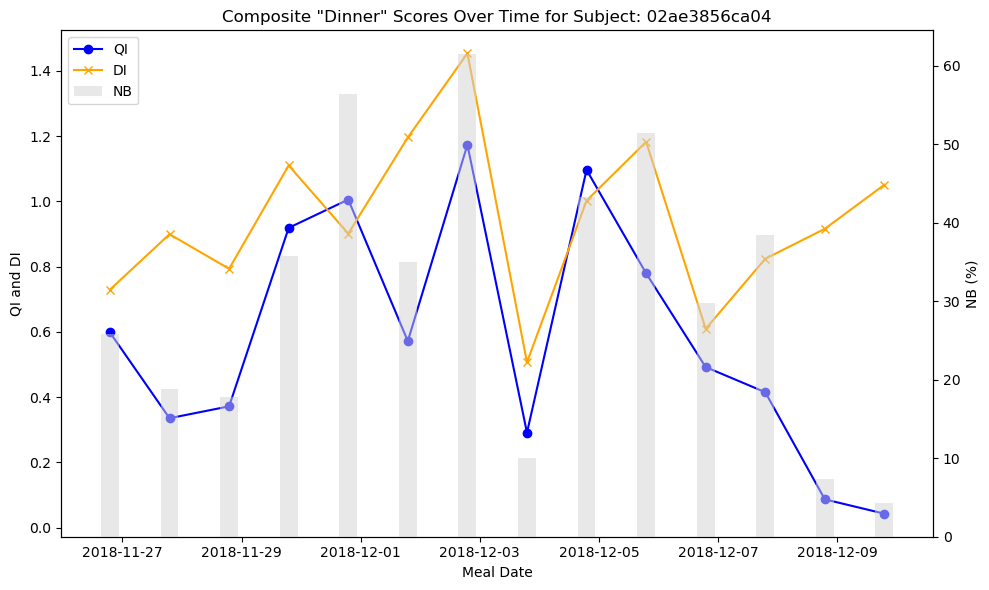

In [29]:
meal_dataframes = {
    'breakfast': composite_breakfast,
    'lunch': composite_lunch,
    'snack': composite_snack,
    'dinner': composite_dinner
}

# And a corresponding mapping for the standardized time columns:
meal_time_columns = {
    'breakfast': 'breakfast_time',
    'lunch': 'lunch_time',
    'snack': 'snack_time',
    'dinner': 'dinner_time'
}

subject_id = '02ae3856ca04'

for meal, df_meal in meal_dataframes.items():
    # Filter for the subject of interest:
    subject_df = df_meal[df_meal['subject_key'] == subject_id]
    if subject_df.empty:
        print(f"No {meal} data for subject {subject_id}.")
    else:
        save_filename = f"composite_{meal}_subject_{subject_id}.png"
        save_path = os.path.join(save_directory, save_filename)
        print(f"Plotting {meal} for subject {subject_id} and saving to {save_path}.")
        plot_meal(subject_df, subject_id, meal_name=meal, time_column=meal_time_columns[meal], save_path=save_path)

Plotting breakfast for subject 02ae3856ca04 on 2018-12-06...


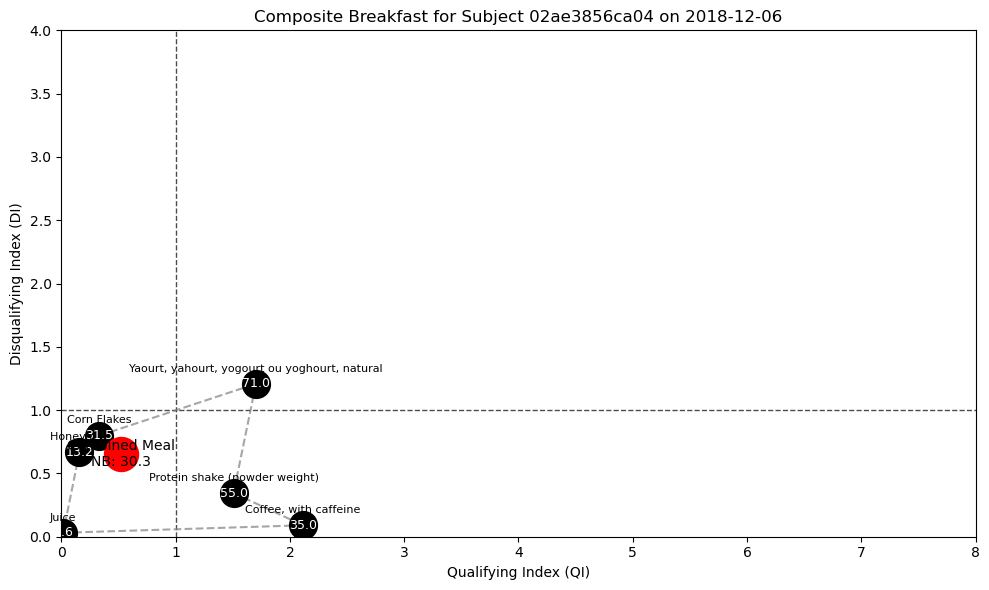

Plotting lunch for subject 02ae3856ca04 on 2018-12-06...


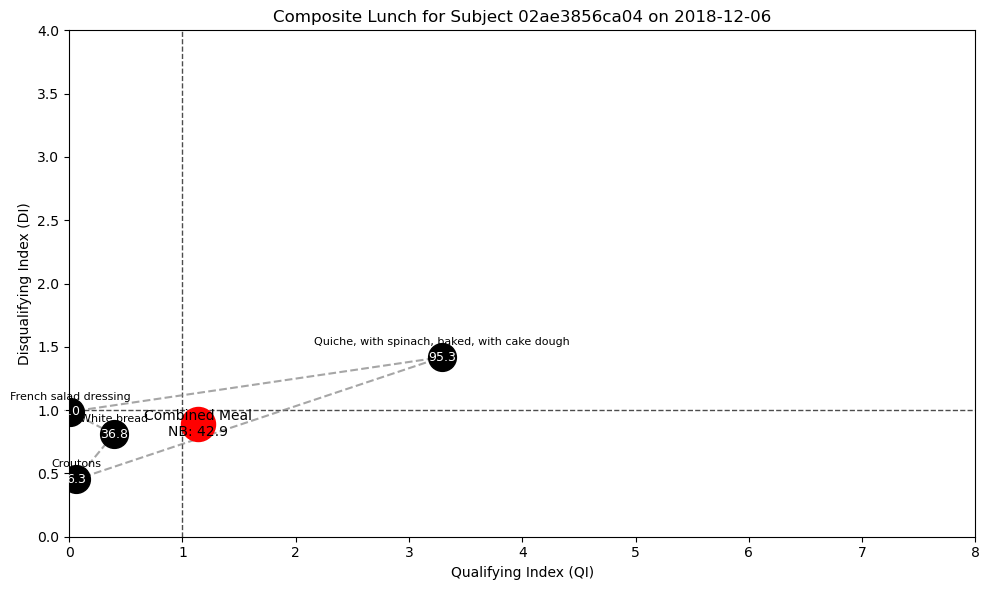

Plotting snack for subject 02ae3856ca04 on 2018-12-06...
No data for subject 02ae3856ca04 on 2018-12-06 for snack.
Plotting dinner for subject 02ae3856ca04 on 2018-12-06...


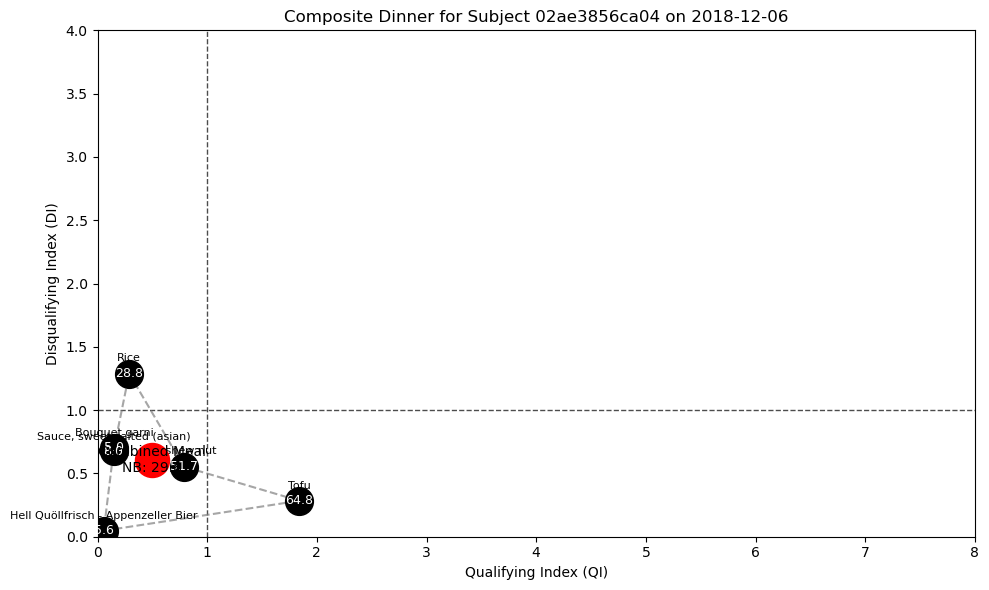

In [30]:
meal_types = ['breakfast', 'lunch', 'snack', 'dinner']

subject_id = '02ae3856ca04'
target_date = pd.to_datetime('2018-12-06').date()

for meal in meal_types:
    print(f"Plotting {meal} for subject {subject_id} on {target_date}...")
    save_filename = f"composite_{meal}_subject_{subject_id}_{target_date}.png"
    save_path = os.path.join(save_directory, save_filename)
    plot_meal_composite(df_food_clean_outliers, subject_id, target_date, meal, save_path=save_path)

### Daywise

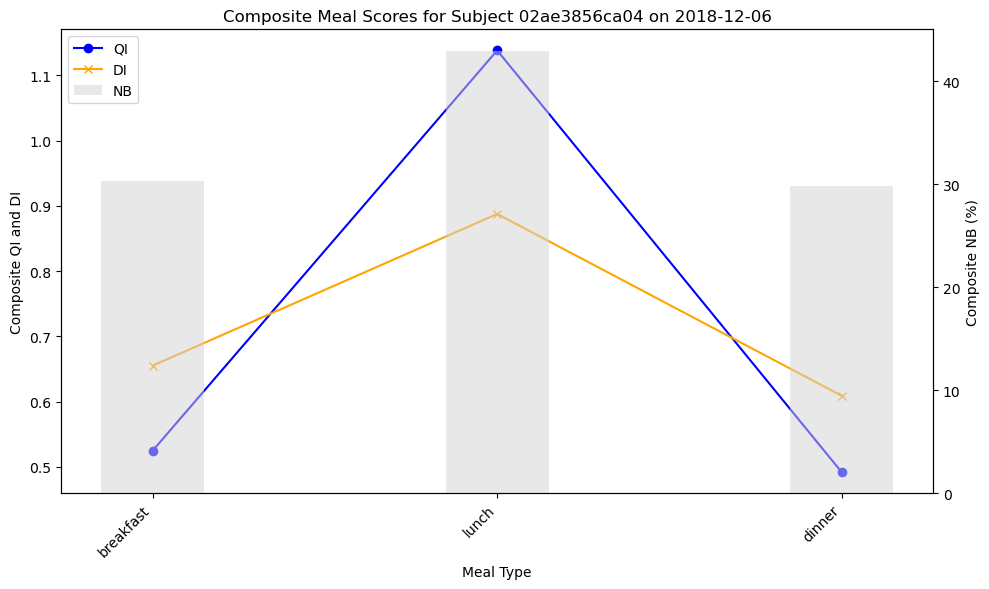

,subject_key,date,meal,total_energy,QI,DI,NB
31,02ae3856ca04,2018-12-06,breakfast,508.250,0.525091,0.655378,30.335425
33,02ae3856ca04,2018-12-06,lunch,395.580,1.138349,0.887722,42.913938
32,02ae3856ca04,2018-12-06,dinner,479.502,0.492099,0.609161,29.811970


In [31]:
subject_id = '02ae3856ca04'
target_date = pd.to_datetime('2018-12-06').date()

df_day = composite_meals[(composite_meals['subject_key'] == subject_id) & 
                         (pd.to_datetime(composite_meals['date']).dt.date == target_date)]

save_filename = f"composite_meals_{subject_id}_{target_date}.png"
save_path = os.path.join(save_directory, save_filename)
plot_day_meals(df_day, subject_id, target_date, save_path=save_path)

# Analysis over days of the week

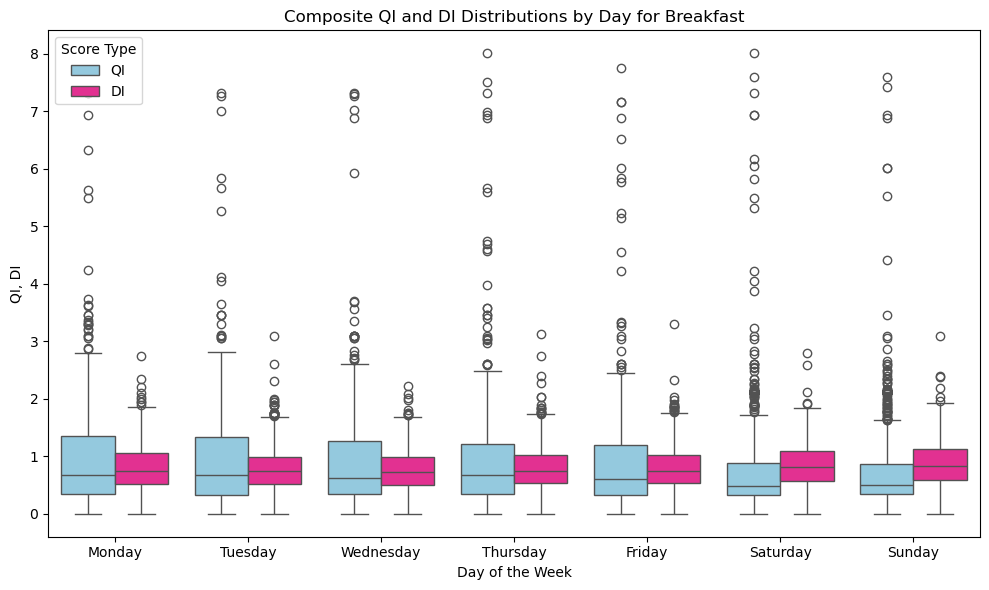

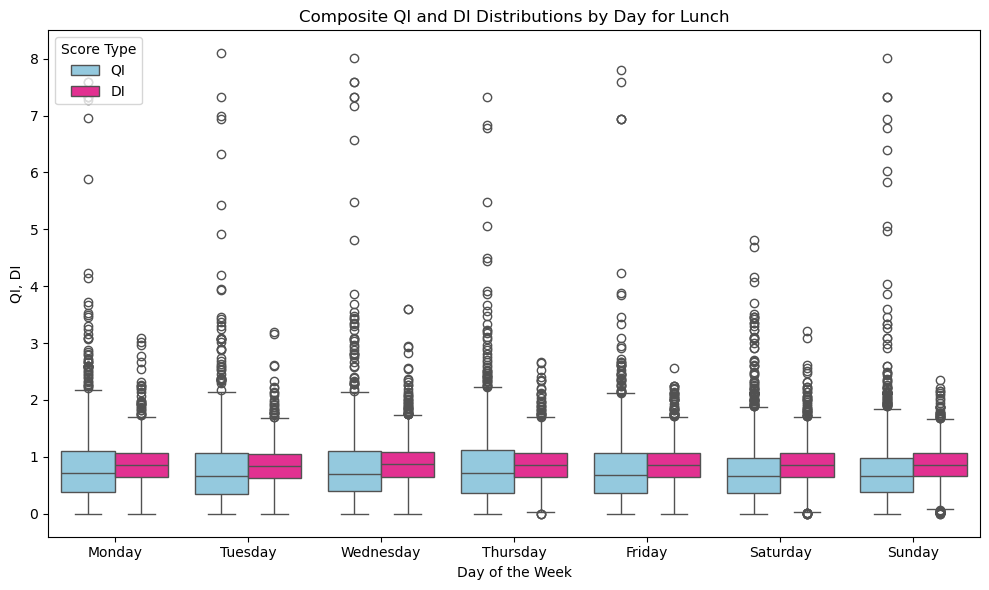

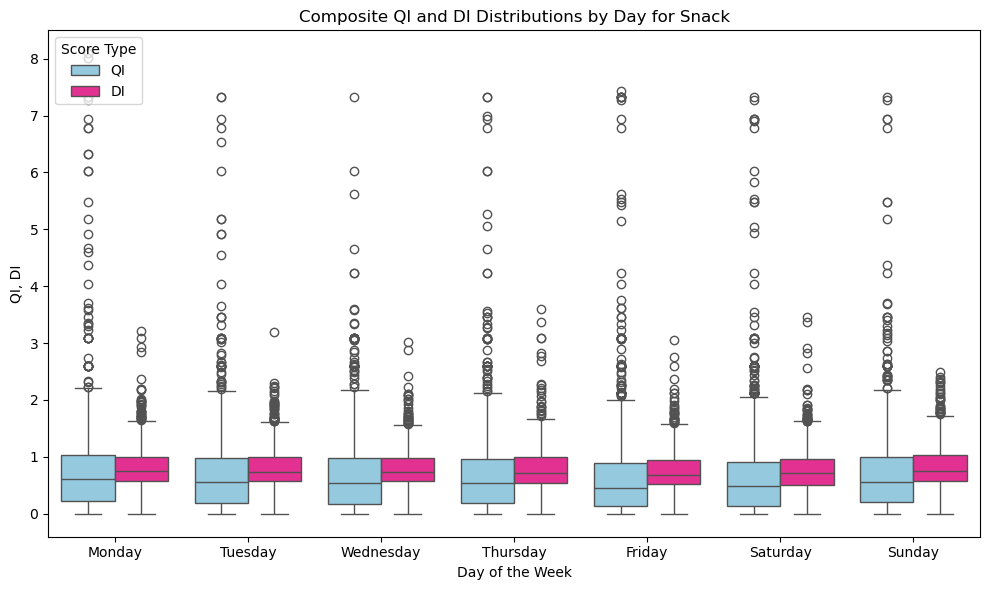

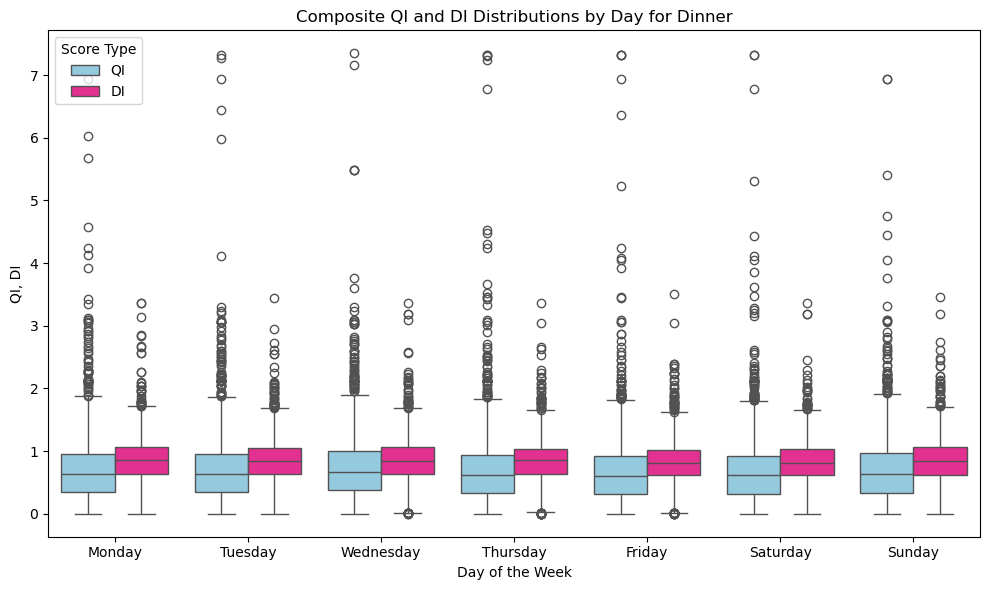

In [47]:
for meal in meal_types:
    save_path = os.path.join(save_directory, f"Daily_QI_DI_Boxplot_{meal}.png")
    plot_daily_qi_di_boxplots(composite_meals, meal_type=meal, save_path=save_path)

In [33]:
composite_meals_days = add_type_of_day(composite_meals)

In [34]:
composite_meals_days

,subject_key,date,meal,total_energy,QI,DI,NB,day_of_week,type_of_day
0,02ae3856ca04,2018-11-26,breakfast,575.00,0.713199,0.798634,41.205509,Monday,weekday
1,02ae3856ca04,2018-11-26,dinner,1287.00,0.598050,0.729423,25.860366,Monday,weekday
2,02ae3856ca04,2018-11-26,lunch,2.00,2.115202,0.090278,35.000000,Monday,weekday
3,02ae3856ca04,2018-11-26,snack,712.40,1.135763,1.184370,48.454579,Monday,weekday
4,02ae3856ca04,2018-11-27,breakfast,306.20,0.523551,0.863543,41.538789,Tuesday,weekday
...,...,...,...,...,...,...,...,...,...
44325,zznk4w,2022-09-24,breakfast,955.85,0.597726,1.036774,24.040702,Saturday,weekend
44326,zznk4w,2022-09-24,dinner,720.05,0.256130,0.985080,20.958660,Saturday,weekend
44327,zznk4w,2022-09-24,lunch,795.25,0.212611,0.752383,17.993521,Saturday,weekend
44328,zznk4w,2022-09-24,snack,132.70,0.778478,0.852516,28.638771,Saturday,weekend


In [35]:
days_of_week_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df = composite_meals_days.copy()
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=days_of_week_order, ordered=True)

# filter out low‐energy meals 
df = df[df['total_energy'] > 0]

grouped = df.groupby(['meal','day_of_week'])[['QI','DI']].agg(['mean','median'])

grouped.columns = ['_'.join(col) for col in grouped.columns]
grouped = grouped.reset_index()

display(grouped.sort_values(['meal','day_of_week']))

C:\Users\Sophie\AppData\Local\Temp\ipykernel_18772\3971574589.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['meal','day_of_week'])[['QI','DI']].agg(['mean','median'])


,meal,day_of_week,QI_mean,QI_median,DI_mean,DI_median
0,breakfast,Monday,0.897373,0.679600,0.750319,0.745270
1,breakfast,Tuesday,0.882711,0.674344,0.737691,0.734662
2,breakfast,Wednesday,0.870379,0.625452,0.725429,0.724825
3,breakfast,Thursday,0.879566,0.665017,0.755836,0.749836
4,breakfast,Friday,0.842903,0.605552,0.753070,0.742522
5,breakfast,Saturday,0.705580,0.484768,0.790697,0.809386
6,breakfast,Sunday,0.678527,0.506424,0.819404,0.822822
7,dinner,Monday,0.731941,0.638712,0.872276,0.860860
8,dinner,Tuesday,0.727281,0.630483,0.851812,0.840078
9,dinner,Wednesday,0.752725,0.662626,0.867411,0.843980


In [36]:
qi_mean_pivot = grouped.pivot(index='day_of_week', columns='meal', values='QI_mean')
di_mean_pivot   = grouped.pivot(index='day_of_week', columns='meal', values='DI_mean')

qi_mean_pivot

meal,breakfast,dinner,lunch,snack
day_of_week,,,,
Monday,0.897373,0.731941,0.844586,0.813626
Tuesday,0.882711,0.727281,0.814500,0.736239
Wednesday,0.870379,0.752725,0.838922,0.714181
Thursday,0.879566,0.721295,0.840738,0.730729
Friday,0.842903,0.684573,0.794057,0.684497
Saturday,0.705580,0.687861,0.754119,0.692560
Sunday,0.678527,0.726820,0.769024,0.735541


In [37]:
di_mean_pivot

meal,breakfast,dinner,lunch,snack
day_of_week,,,,
Monday,0.750319,0.872276,0.869111,0.793332
Tuesday,0.737691,0.851812,0.843719,0.781136
Wednesday,0.725429,0.867411,0.877024,0.777124
Thursday,0.755836,0.847001,0.859616,0.762322
Friday,0.753070,0.817504,0.861353,0.727020
Saturday,0.790697,0.830016,0.874664,0.737952
Sunday,0.819404,0.855767,0.874832,0.796053


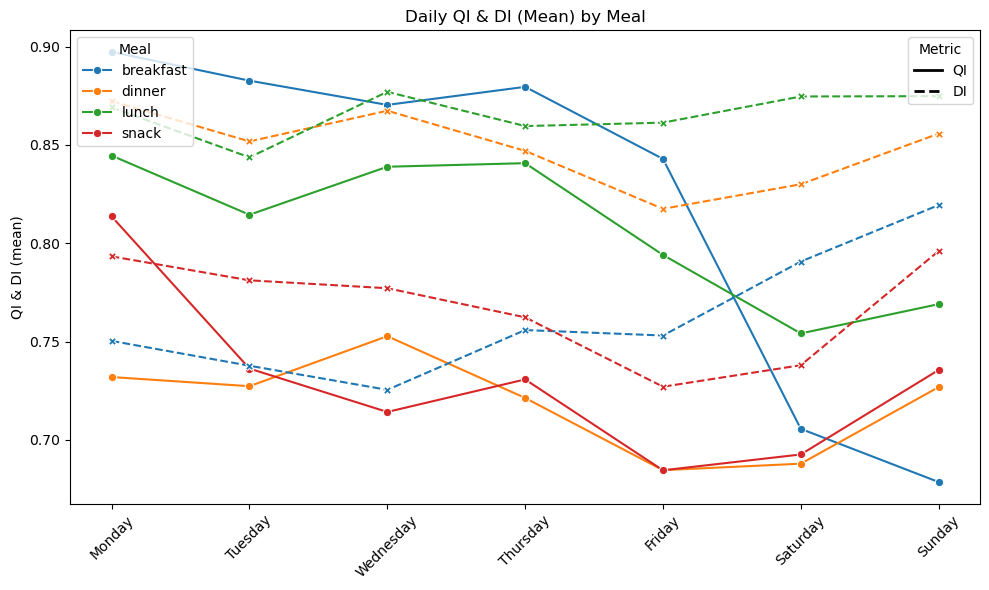

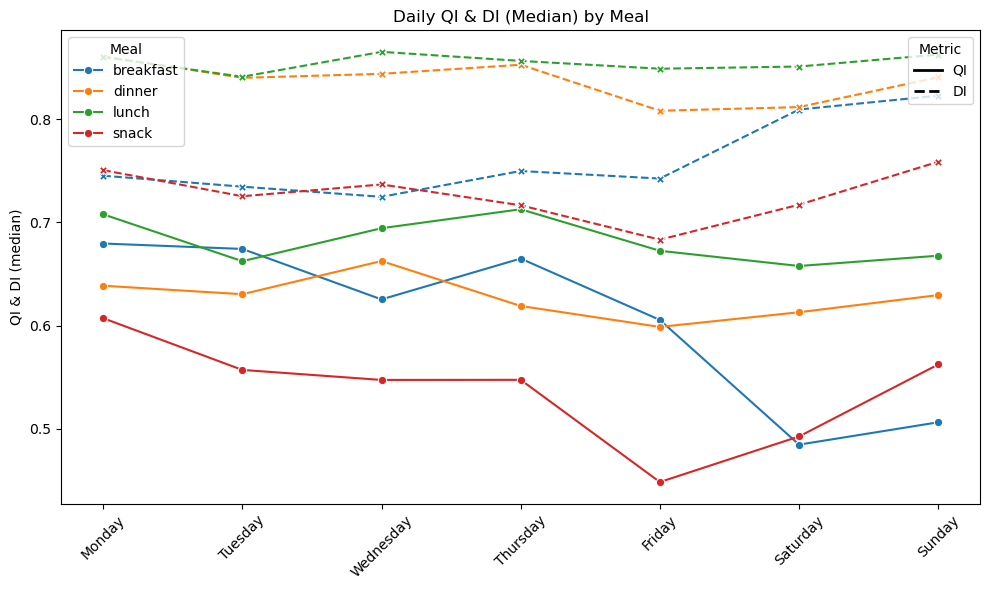

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Daily QI & DI (Median) by Meal'}, ylabel='QI & DI (median)'>)

In [38]:
save_path = os.path.join(save_directory, f"Daily_QI_DI_(mean)_by_meal.png")
plot_qi_di_by_meal(grouped, agg='mean', save_path=save_path)

save_path = os.path.join(save_directory, f"Daily_QI_DI_(median)_by_meal.png")
plot_qi_di_by_meal(grouped, agg='median', save_path=save_path)

In [39]:
test_results = test_weekday_vs_weekend(composite_meals_days)
test_results['significatif'] = test_results['p_value'].apply(star)
test_results

,meal,metric,weekday_n,weekend_n,U_stat,p_value,significatif
0,breakfast,QI,5630,2932,8786011.5,9.291449e-07,****
1,breakfast,DI,5630,2932,7669679.5,7.435969e-08,****
2,dinner,QI,7628,3004,11666891.5,1.412374e-01,ns
3,dinner,DI,7628,3004,11609481.5,2.853850e-01,ns
4,lunch,QI,7395,3291,12467797.0,4.203651e-02,*
5,lunch,DI,7395,3291,12192566.0,8.700053e-01,ns
6,snack,QI,4791,2064,5007948.0,3.972080e-01,ns
7,snack,DI,4791,2064,4956299.0,8.732982e-01,ns


In [40]:
pivot = test_results.pivot(index='meal', columns='metric', values=['p_value','significatif'])
pivot

p_value           significatif      
metric           DI        QI           DI    QI
meal                                            
breakfast       0.0  0.000001         ****  ****
dinner     0.285385  0.141237           ns    ns
lunch      0.870005  0.042037           ns     *
snack      0.873298  0.397208           ns    ns

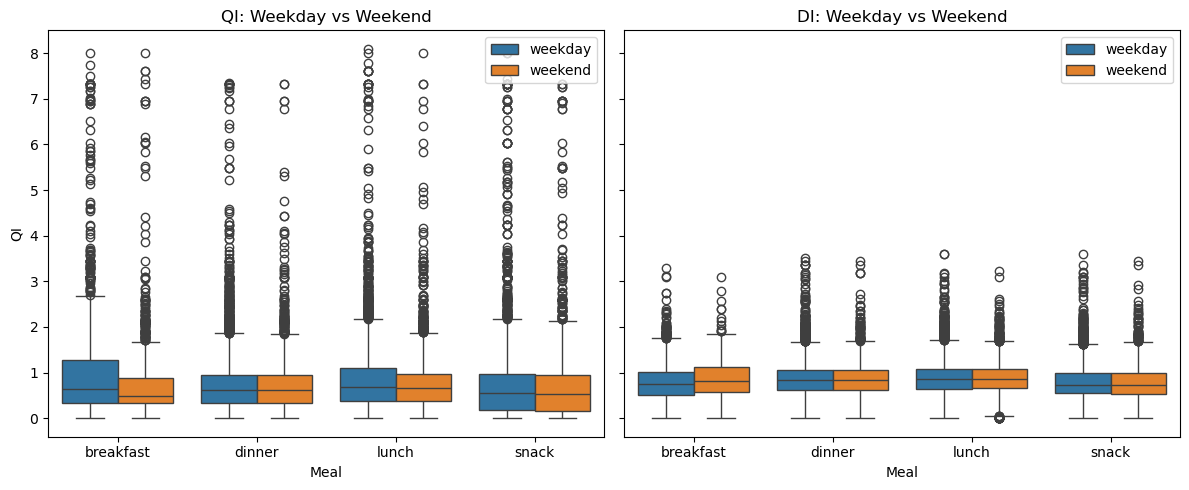

In [41]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharey=True)
sns.boxplot(x='meal', y='QI', hue='type_of_day', data=composite_meals_days.query("total_energy> 0"), ax=axes[0])
axes[0].set_title("QI: Weekday vs Weekend")
sns.boxplot(x='meal', y='DI', hue='type_of_day', data=composite_meals_days.query("total_energy> 0"), ax=axes[1])
axes[1].set_title("DI: Weekday vs Weekend")
for ax in axes:
    ax.legend(title="")
    ax.set_xlabel("Meal")

save_path = os.path.join(save_directory, f"QI_DI_weekday_vs_weekend.png")
plt.savefig(save_path)
plt.tight_layout()
plt.show()

Saved to composite_meals_graphs\Monday_QI_DI_by_meal.png


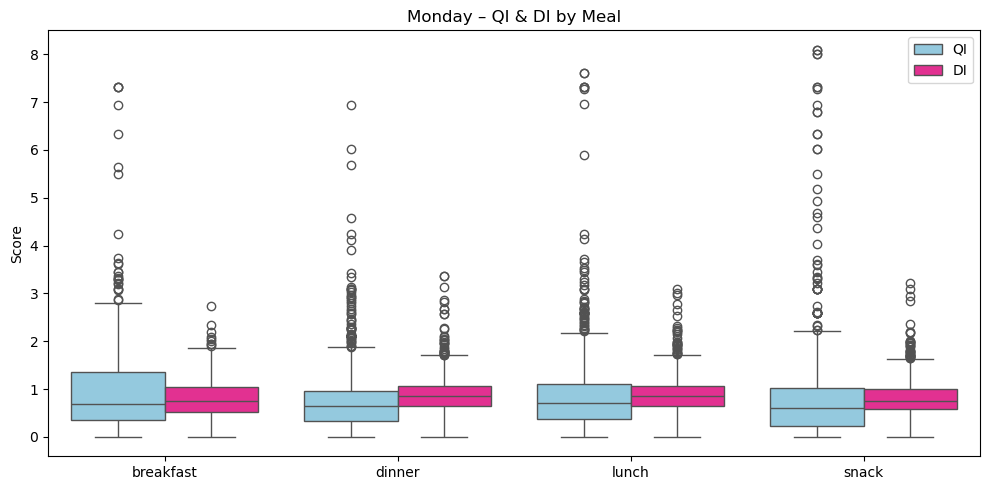

Saved to composite_meals_graphs\Tuesday_QI_DI_by_meal.png


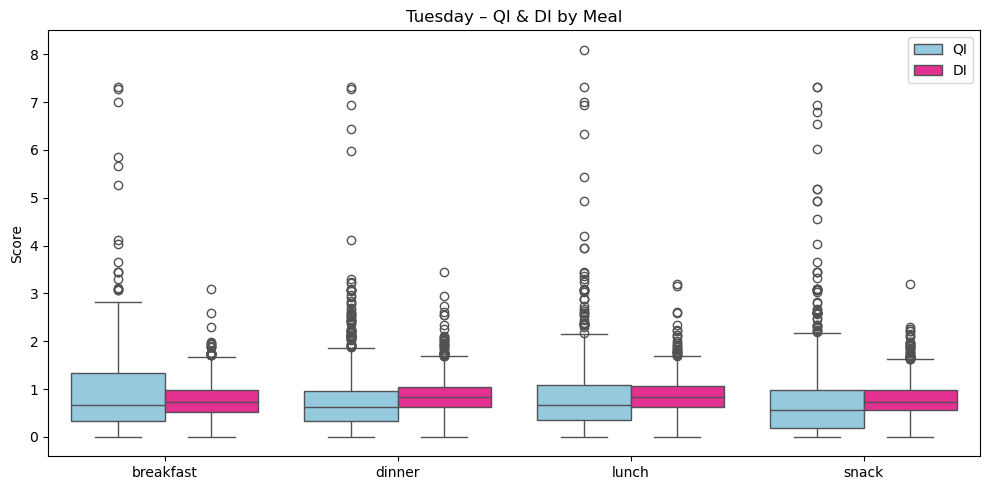

Saved to composite_meals_graphs\Wednesday_QI_DI_by_meal.png


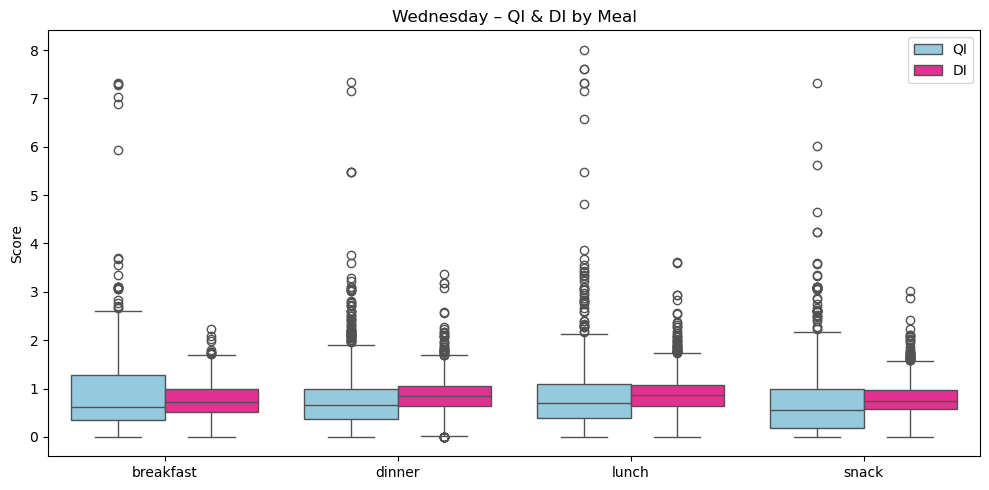

Saved to composite_meals_graphs\Thursday_QI_DI_by_meal.png


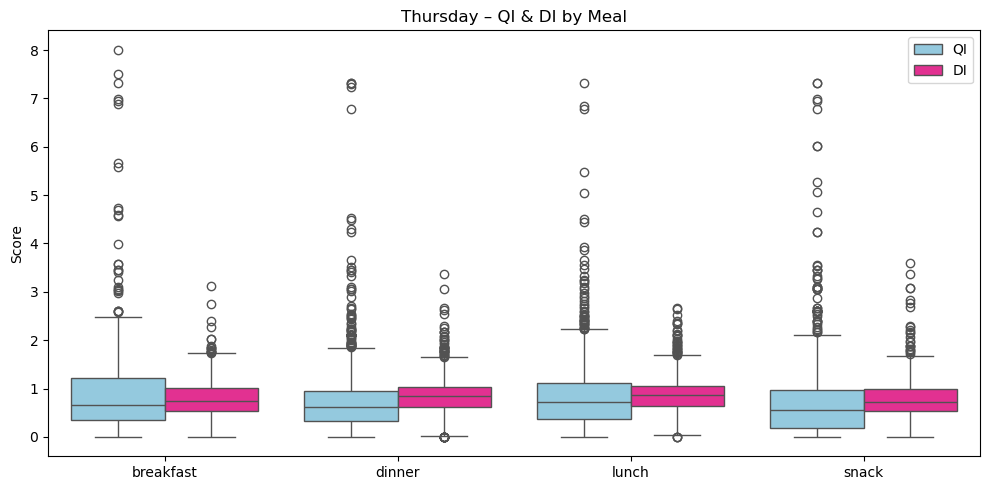

Saved to composite_meals_graphs\Friday_QI_DI_by_meal.png


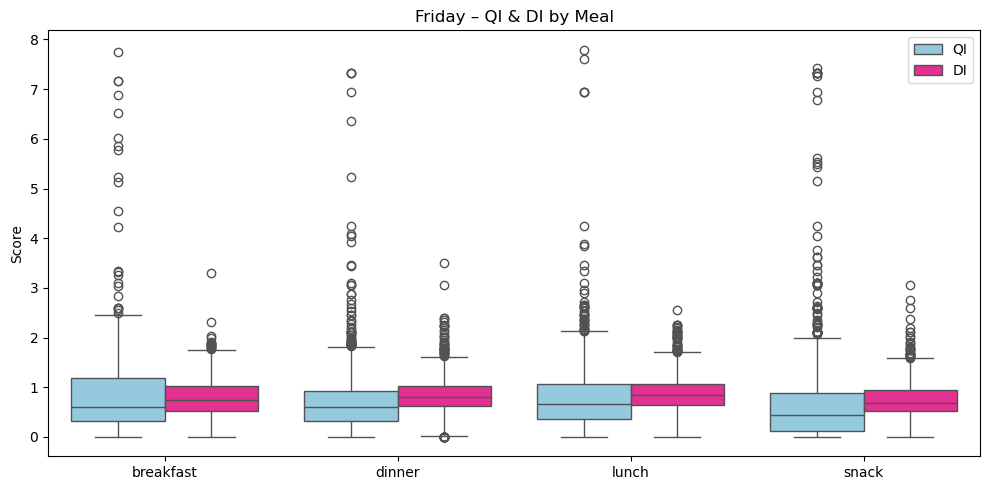

Saved to composite_meals_graphs\Saturday_QI_DI_by_meal.png


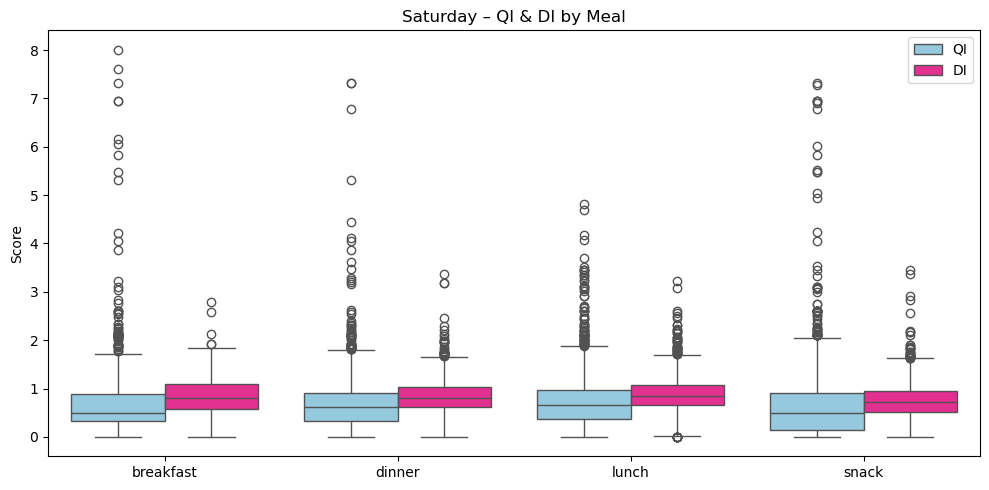

Saved to composite_meals_graphs\Sunday_QI_DI_by_meal.png


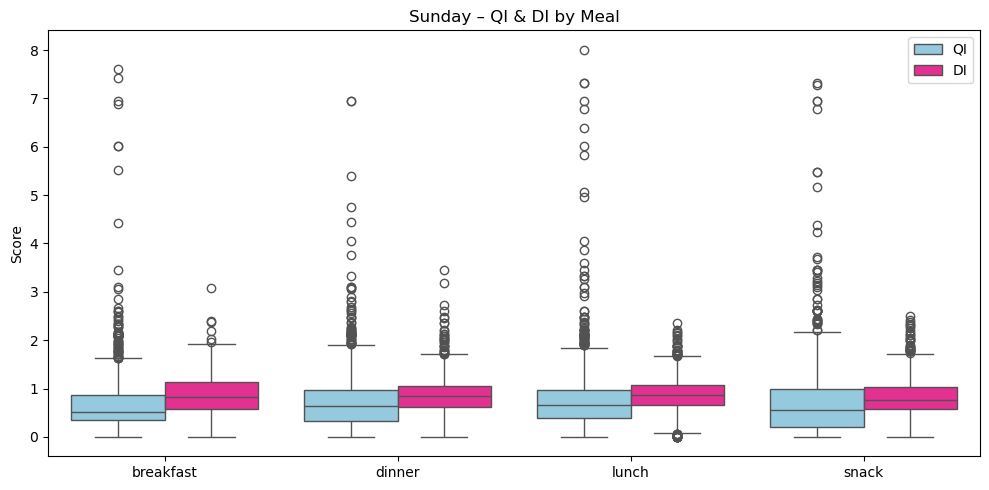

In [49]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for d in days:
    save_path = os.path.join(save_directory, f"{d}_QI_DI_by_meal.png")
    boxplot_qi_di_by_meal_for_day(
      composite_meals_days,
      day_of_week=d,
      save_path=save_path
    )

**Breakfast** : = QI is always higher in weekdays compared to the weekend

**Lunch** : = Same as breakfast, QI is generally higher in weekdays compared to the weekend

**Dinner** : = For dinner, DI is always higher, independently of the day of the week

**Snack** : = As for snack, QI seems higher at the beginning of the week (Monday to Wednesday), and after DI become higher the last part of the week

In [56]:
qualifying_nutrients = {nutr: info for nutr, info in nutrient_info.items() if info['type'] == 'qualifying'}
disqualifying_nutrients = {nutr: info for nutr, info in nutrient_info.items() if info['type'] == 'disqualifying'}

qualifying_list   = list(qualifying_nutrients.keys())
disqualifying_list = list(disqualifying_nutrients.keys())
nutrient_list = qualifying_list + disqualifying_list

In [78]:
meal_nutrient = aggregate_meal_nutrients_fast(df_food_clean_outliers, nutrient_list)
df_meal_nutrient = composite_meals.merge(
    meal_nutrient,
    on=['subject_key','date','meal'],
    how='left'
)

In [97]:
qi_impacts = rank_nutrient_impact_fast(
    df=df_meal_nutrient, 
    score_col='QI',
    nutrient_list=qualifying_list
)

di_impacts = rank_nutrient_impact_fast(
    df=df_meal_nutrient, 
    score_col='DI',
    nutrient_list=disqualifying_list
)


**Why it works**  
 If  
$$
\text{QI}_i = \frac{1}{p}\sum_{k=1}^p x_{ik},
$$
then leaving nutrient $j$ out gives  
$$
\text{QI}_{i,\,-j} = \frac{1}{p-1}\sum_{k\neq j} x_{ik}
= \frac{p\,\text{QI}_i - x_{ij}}{p-1}
$$  
and so  
$$
\text{QI}_i - \text{QI}_{i,\,-j}
= \frac{x_{ij} - \text{QI}_i}{p-1}.
$$  


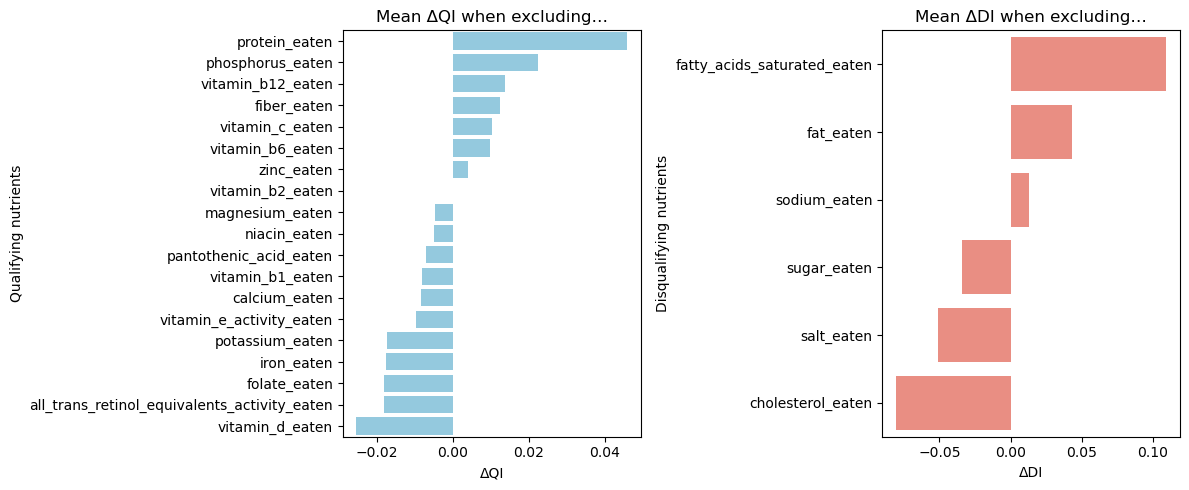

In [101]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5), sharey=False)

sns.barplot(x=qi_impacts.values, y=qi_impacts.index, ax=ax1, color='skyblue')
ax1.set_title("Mean ΔQI when excluding…")
ax1.set_xlabel("ΔQI")
ax1.set_ylabel('Qualifying nutrients')

sns.barplot(x=di_impacts.values, y=di_impacts.index, ax=ax2, color='salmon')
ax2.set_title("Mean ΔDI when excluding…")
ax2.set_xlabel("ΔDI")
ax2.set_ylabel('Disqualifying nutrients')

save_path = os.path.join(save_directory, f"Impact_of_nutrient_over_QI_DI.png")
plt.savefig(save_path)
plt.tight_layout()
plt.show()

- a positive bar mean that the index drops when that nutrient is excluded
- a negative bar mean that the index rises when that nutrient is excluded
